In [15]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from IPython.core.debugger import set_trace


import os
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [16]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [17]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,19.065,19.4160,19.0650,19.4160,72019,0
2005-02-28,20.172,20.1720,19.3120,19.3800,101346,0
2005-03-01,19.798,19.7980,19.2090,19.2680,53671,0
2005-03-02,19.109,19.1950,19.0420,19.1600,23894,0
2005-03-03,19.744,19.7440,19.1270,19.1870,28870,0
...,...,...,...,...,...,...
2017-11-06,43.000,43.6084,43.0000,43.5700,11601,0
2017-11-07,43.680,43.6800,43.1700,43.2491,3400,0
2017-11-08,43.260,43.4928,43.2600,43.4357,2602,0


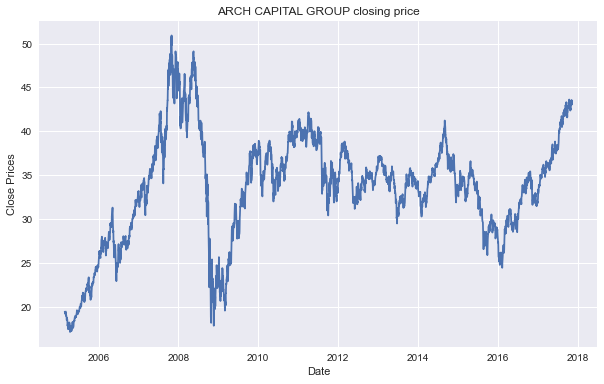

In [18]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<AxesSubplot: ylabel='Density'>

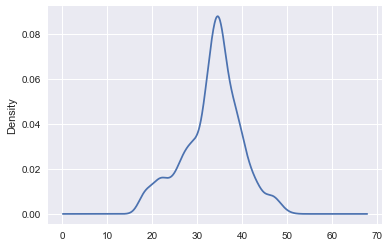

In [19]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

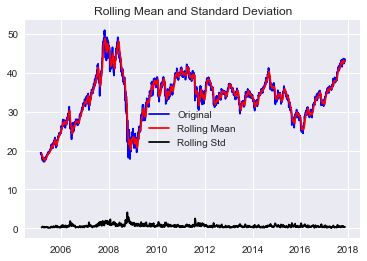

Results of dickey fuller test
Test Statistics                  -2.831349
p-value                           0.053933
No. of lags used                 20.000000
Number of observations used    3180.000000
critical value (1%)              -3.432408
critical value (5%)              -2.862449
critical value (10%)             -2.567254
dtype: float64


In [20]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


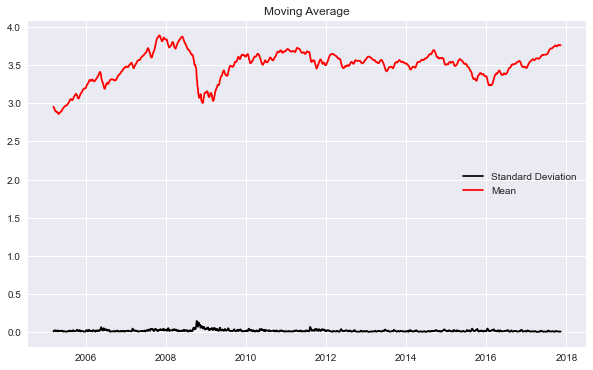

In [21]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

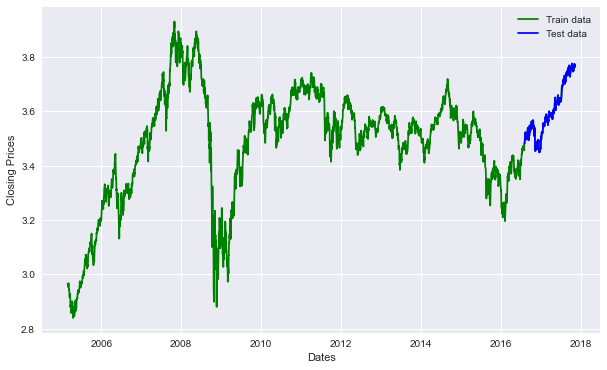

In [22]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14574.550, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14584.047, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14586.017, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14576.311, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14589.334, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14600.337, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14599.367, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-14597.274, Time=1.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14598.129, Time=1.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14600.151, Time=1.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14599.437, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-14597.126, Time=3.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-14602.043, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14596.195, Time=1.26 sec
 ARIM

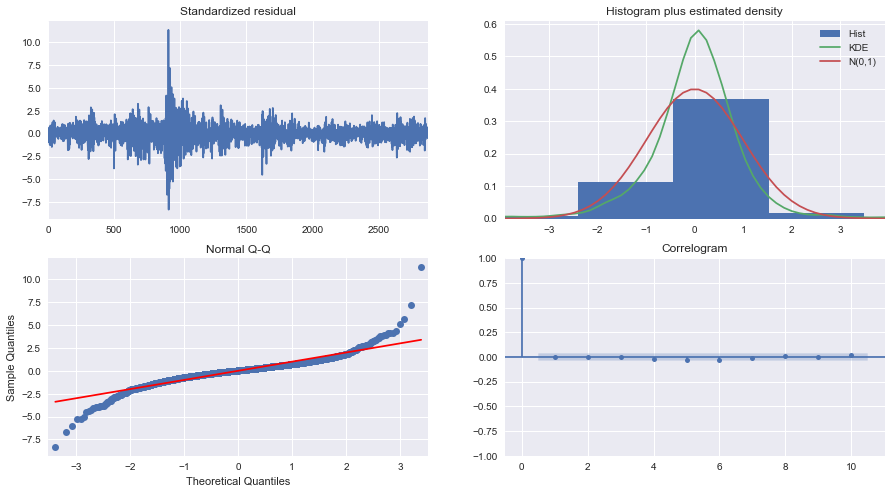

In [23]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [29]:
arima_train = sm.tsa.arima.ARIMA(train_data, order=(2, 1, 1)).fit()

In [30]:
print(arima_train.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2877
Model:                 ARIMA(2, 1, 1)   Log Likelihood                7305.021
Date:                Thu, 01 Dec 2022   AIC                         -14602.043
Time:                        11:50:10   BIC                         -14578.186
Sample:                             0   HQIC                        -14593.443
                               - 2877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4138      0.104     -3.995      0.000      -0.617      -0.211
ar.L2         -0.1000      0.011     -9.422      0.000      -0.121      -0.079
ma.L1          0.3487      0.103      3.371      0.0

In [37]:
fc = arima_train.forecast(339, alpha=0.05)
se = arima_train.forecast(339, alpha=0.05)
conf = arima_train.forecast(339, alpha=0.05)


In [34]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'

In [51]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

NameError: name 'fc' is not defined